In [118]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-data/car_data.csv


In [119]:
df=pd.read_csv('/kaggle/input/car-data/car_data.csv') #load the dataset into the notebook
df.drop_duplicates(inplace=True) # remove duplicate entries
print(df.isnull().sum()) # find the count of null values in each column

Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3376
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64


In [120]:
#initial cleaning of the dataset to remove incorrect values and impute null values
#Find mode of transmission type for each Make type   
b=df.groupby('Make')['Transmission Type'].transform(lambda x: x.mode().iloc[0])
#replace "Unknown" with mode of each Make type 
df.loc[df['Transmission Type'] == 'UNKNOWN', 'Transmission Type'] = b   
#print(df['Transmission Type'].value_counts())

In [121]:
#Market category has around 3000 null values and it is replaced by most common category for each make type by usig Mode method
#mode of Market category for each Make
m=df.groupby('Make')['Market Category'].transform(lambda x: x.mode().iloc[0])
#print(m)

#filling the missing values by the above value
df.fillna({'Market Category':m},inplace=True)

In [122]:
def hp(a):
    
    if a['Engine Fuel Type']=='electric':
        return 0
    else:
        return a['Engine HP']


def fi(a):
    
    if a['Model']=='Model S':
        return 4
    elif a['Model']=='FF':
        return 2
    else:
        return a['Number of Doors']
    
df.fillna({'Engine HP':df.apply(hp,axis=1),'Number of Doors':df.apply(fi,axis=1),'Engine Fuel Type':'regular unleaded','Engine Cylinders':0},inplace=True)

#e=df.groupby('Model')['Engine HP'].mean() would still give correct ans but inorder to fill for missing values it should be aligned iwth original df to fill in null values hence transform function
e=df.groupby('Model')['Engine HP'].transform('mean')
df['Engine HP'].fillna(e,inplace=True)
print(df.isnull().sum()) # check for count of null values after impuation in  each columns

Make                 0
Model                0
Year                 0
Engine Fuel Type     0
Engine HP            0
Engine Cylinders     0
Transmission Type    0
Driven_Wheels        0
Number of Doors      0
Market Category      0
Vehicle Size         0
Vehicle Style        0
highway MPG          0
city mpg             0
Popularity           0
MSRP                 0
dtype: int64


/tmp/ipykernel_33/3853691452.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Engine HP'].fillna(e,inplace=True)


           Engine HP      MSRP
Engine HP   1.000000  0.650203
MSRP        0.650203  1.000000


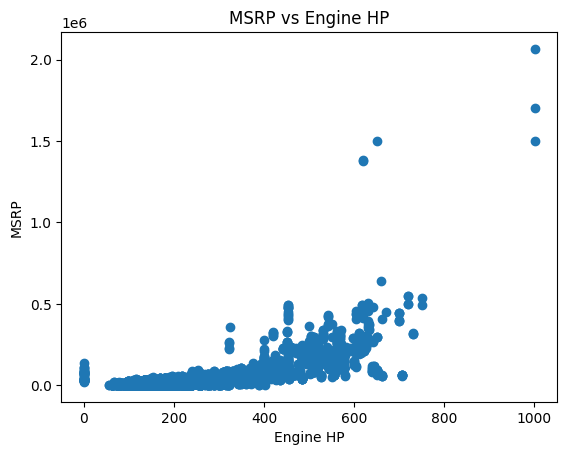

In [123]:
#relationship between a car's engine power and its price 
print( df[['Engine HP', 'MSRP']].corr()) #Correlation coefficient of Engine HP and MSRP
plt.scatter(df['Engine HP'],df['MSRP']) #scatter plot to vizualize correlation

# Add labels and title
plt.xlabel('Engine HP')
plt.ylabel('MSRP')
plt.title('MSRP vs Engine HP')

# Show plot
plt.show()

                  Engine Cylinders  highway MPG
Engine Cylinders          1.000000    -0.610338
highway MPG              -0.610338     1.000000


Text(0.5, 1.0, 'Engine Cylinders vs highway MPG')

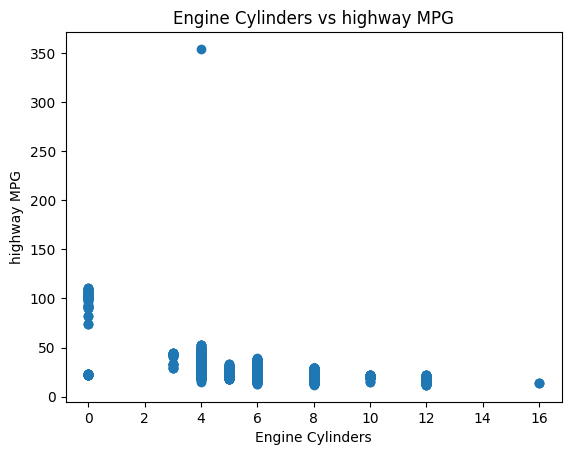

In [124]:

print( df[['Engine Cylinders','highway MPG']].corr())
plt.scatter(df['Engine Cylinders'],df['highway MPG'])

plt.xlabel('Engine Cylinders')
plt.ylabel('highway MPG')
plt.title('Engine Cylinders vs highway MPG')


                  Engine Cylinders      MSRP
Engine Cylinders          1.000000  0.533431
MSRP                      0.533431  1.000000


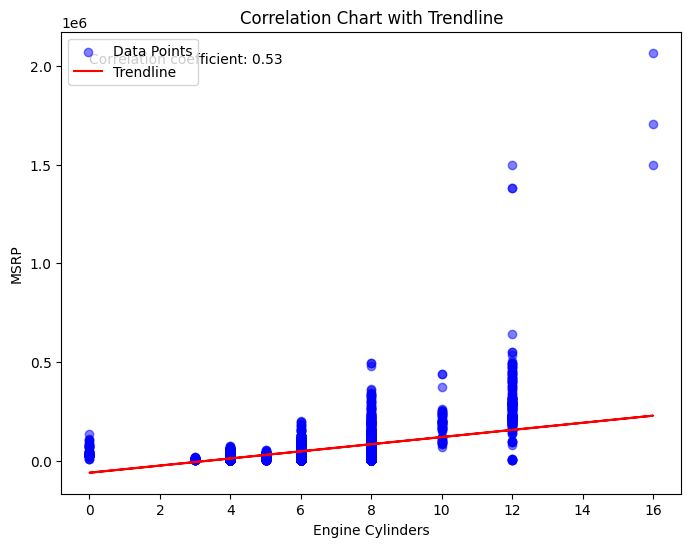

In [125]:
#import necessary libraries to perform regression analysis
from scipy import stats
from scipy.stats import linregress
print( df[['Engine Cylinders','MSRP']].corr())
x = df['Engine Cylinders']  
y = df['MSRP']
slope, intercept, r_value, p_value, std_err = linregress(x, y)


plt.figure(figsize=(8, 6))
plt.scatter(x, y, color='blue', alpha=0.5, label='Data Points')

plt.plot(x, slope * x + intercept, color='red', label='Trendline')
# Add correlation coefficient to the plot
plt.text(x.min(), y.max(), f'Correlation coefficient: {r_value:.2f}', ha='left', va='top')
plt.xlabel('Engine Cylinders')
plt.ylabel('MSRP')
plt.title('Correlation Chart with Trendline')
plt.legend()
plt.show()

                  Coefficient
Engine HP          318.020613
Engine Cylinders  6734.674386
Number of Doors  -4423.385047
highway MPG       1417.035299


<Figure size 1000x600 with 0 Axes>

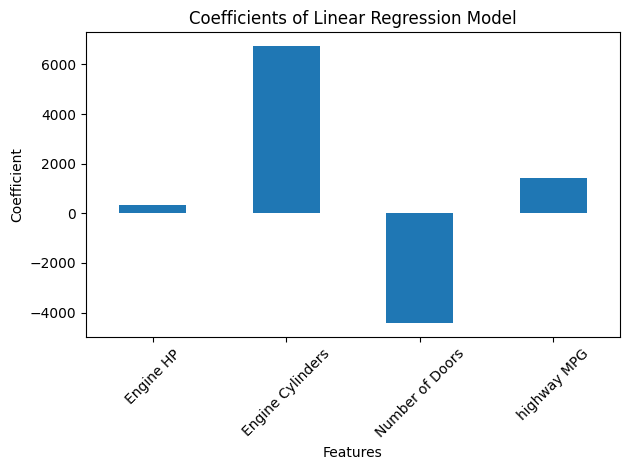

In [126]:
from sklearn import linear_model
x=df[['Engine HP','Engine Cylinders','Number of Doors','highway MPG']]
y=df['MSRP']
r=linear_model.LinearRegression()
r.fit(x,y)
coefficients_df = pd.DataFrame(r.coef_, index=x.columns, columns=['Coefficient'])

# Print the DataFrame
print(coefficients_df)
#print(r.coef_)
#print(r.predict(x))
plt.figure(figsize=(10, 6))
coefficients_df.plot(kind='bar', legend=None)
plt.title('Coefficients of Linear Regression Model')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

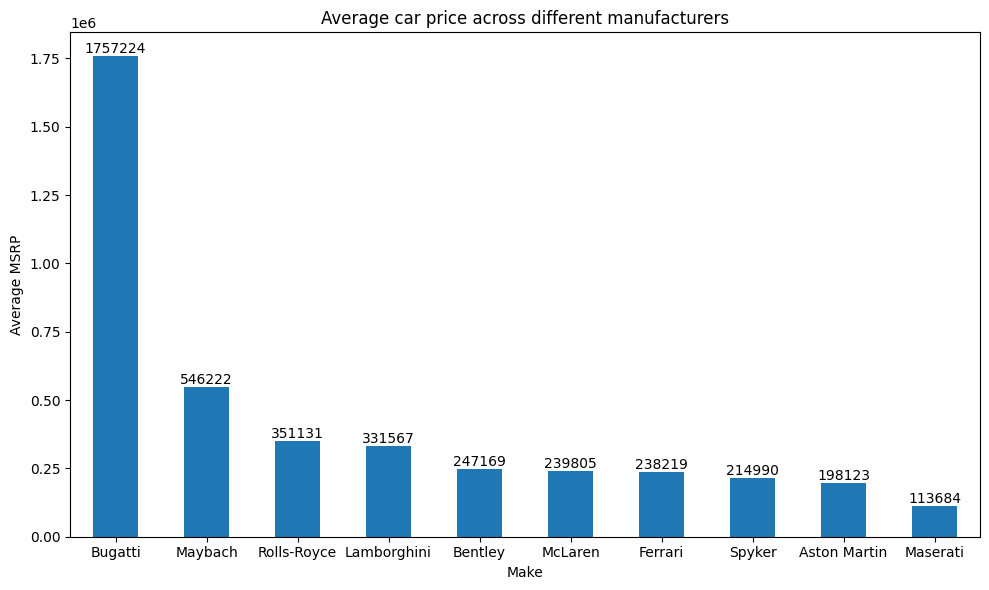

In [127]:
a=df.groupby('Make')['MSRP'].mean()

plt.figure(figsize=(10, 6))

for i, v in enumerate(a.nlargest(10)):
    plt.text(i, v, f'{v:.0f}', ha='center', va='bottom')
a.nlargest(10).plot(kind='bar', legend=None)
plt.title('Average car price across different manufacturers')
plt.xlabel('Make')
plt.ylabel('Average MSRP')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

                                                        mean  count
Market Category                                                    
Crossover                                        1422.544413   2443
Crossover,Diesel                                  873.000000      7
Crossover,Exotic,Luxury,High-Performance          238.000000      1
Crossover,Exotic,Luxury,Performance               238.000000      1
Crossover,Factory Tuner,Luxury,High-Performance  1823.461538     26
...                                                      ...    ...
Luxury,Hybrid                                     673.634615     52
Luxury,Performance                               1293.062215    659
Luxury,Performance,Hybrid                        2333.181818     11
Performance                                      1010.760956    753
Performance,Hybrid                                155.000000      1

[71 rows x 2 columns]
                                mean  count
Market Category                            
Cross

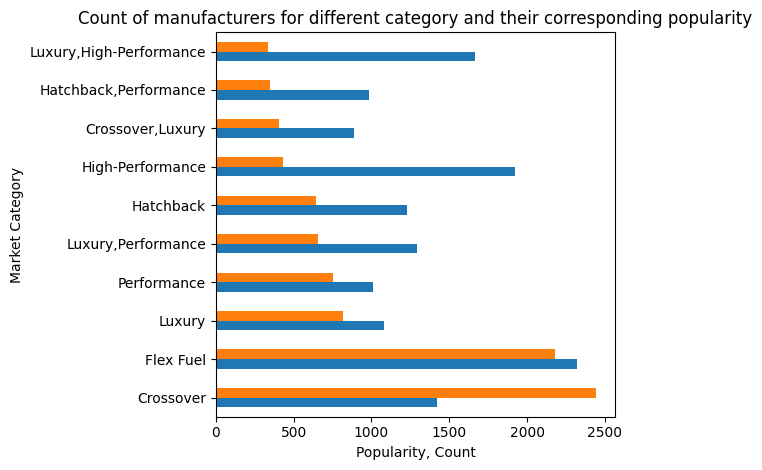

In [128]:
b=df.groupby('Market Category')['Popularity'].agg(['mean','count'])
print(b)
top10=b.nlargest(10,'count')
print(top10)  
for i, v in enumerate(top10):
    if isinstance(v, (int, float)):  # Check if v is a numerical value
        plt.text(i, v, f'{v:.0f}', ha='center', va='bottom')
top10.plot(kind='barh', legend=None)
plt.title('Count of manufacturers for different category and their corresponding popularity')
plt.xlabel('Popularity, Count')
plt.ylabel('Market Category')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()